This notebook was run on google collab

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [3]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [6]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


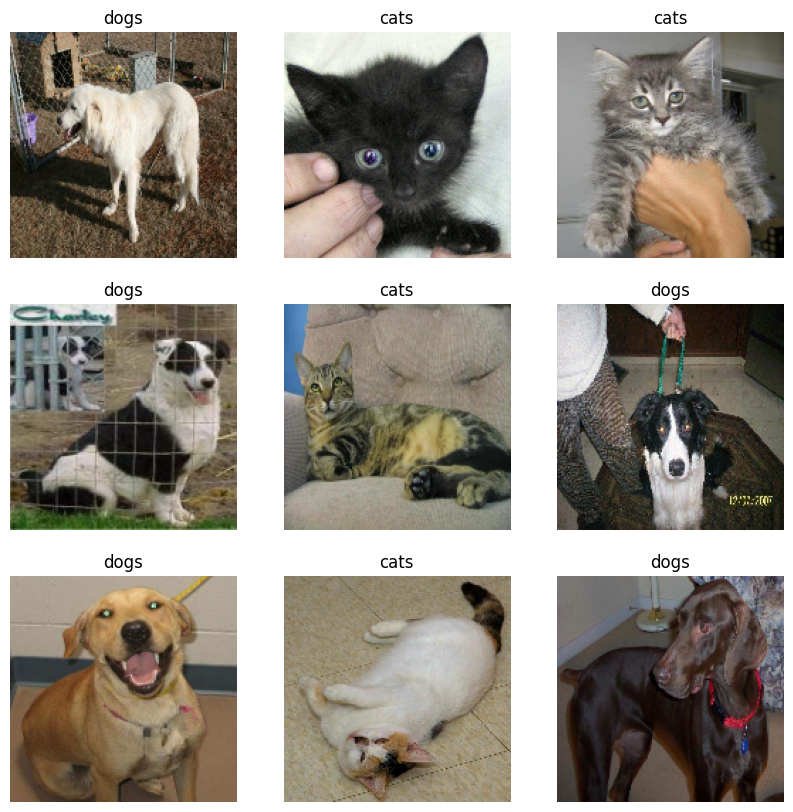

In [7]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 4)
validation_dataset = validation_dataset.skip(val_batches // 4)

In [9]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 24
Number of test batches: 8


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [12]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [16]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

94765736/94765736 [==============================] - 0s 0us/step


In [17]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


In [18]:
base_model.trainable = False

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [20]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [21]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 160, 160, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 160, 160, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0     

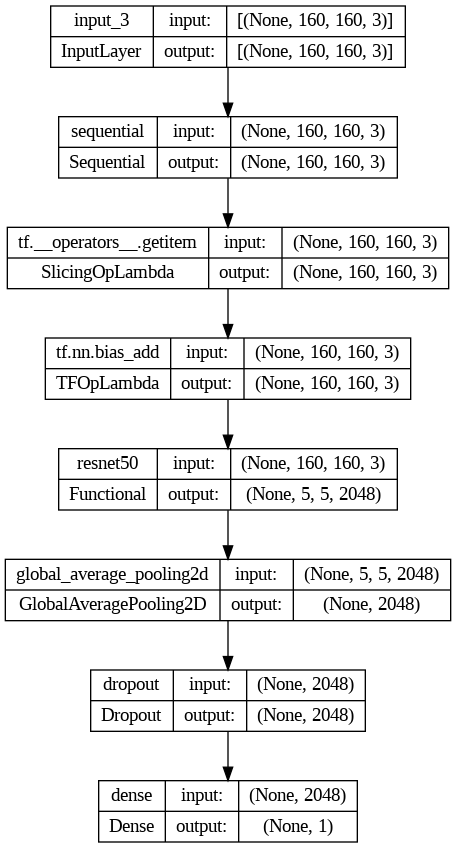

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [25]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

24/24 [==============================] - 82s 3s/step - loss: 1.0908 - accuracy: 0.4328


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.09
initial accuracy: 0.43


In [27]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 287s 4s/step - loss: 0.7888 - accuracy: 0.5905 - val_loss: 0.5717 - val_accuracy: 0.7204
Epoch 2/10
63/63 [==============================] - 283s 4s/step - loss: 0.5153 - accuracy: 0.7535 - val_loss: 0.3515 - val_accuracy: 0.8616
Epoch 3/10
63/63 [==============================] - 284s 5s/step - loss: 0.3943 - accuracy: 0.8360 - val_loss: 0.2412 - val_accuracy: 0.9140
Epoch 4/10
63/63 [==============================] - 285s 5s/step - loss: 0.3050 - accuracy: 0.8760 - val_loss: 0.1908 - val_accuracy: 0.9315
Epoch 5/10
63/63 [==============================] - 283s 5s/step - loss: 0.2621 - accuracy: 0.8870 - val_loss: 0.1652 - val_accuracy: 0.9422
Epoch 6/10
63/63 [==============================] - 282s 4s/step - loss: 0.2561 - accuracy: 0.8940 - val_loss: 0.1433 - val_accuracy: 0.9516
Epoch 7/10
63/63 [==============================] - 282s 5s/step - loss: 0.2297 - accuracy: 0.9045 - val_loss: 0.1273 - val_accuracy: 0.9583
Epoch 8/10
63

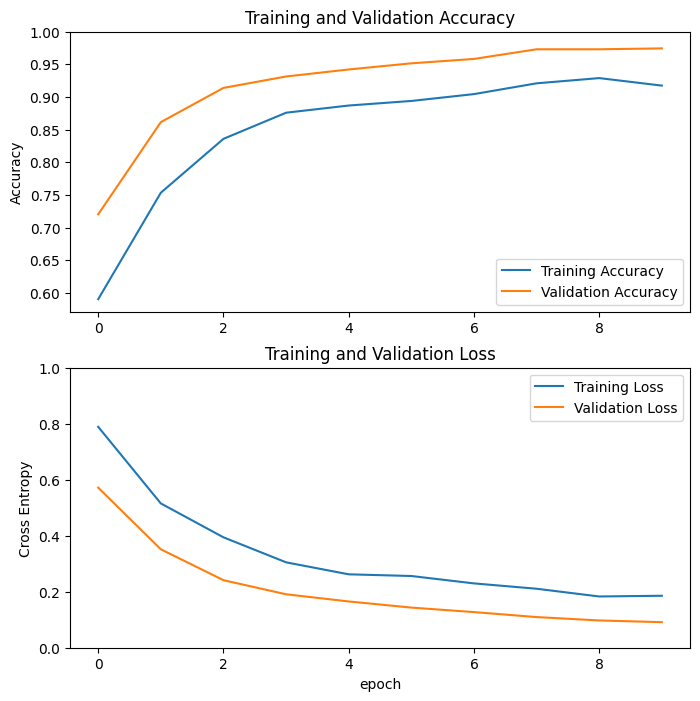

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

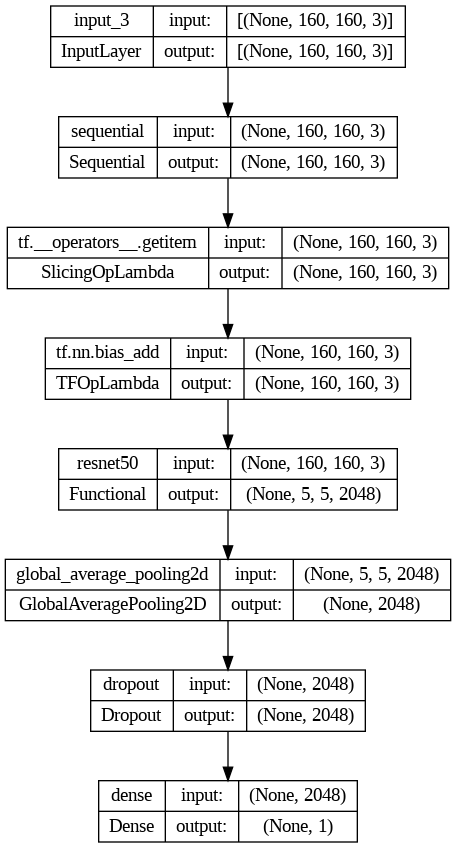

In [29]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [34]:
model.trainable_variables

[<tf.Variable 'dense/kernel:0' shape=(2048, 1) dtype=float32, numpy=
 array([[ 0.03351802],
        [-0.0515576 ],
        [ 0.01924573],
        ...,
        [-0.00814917],
        [ 0.02826465],
        [ 0.02777765]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.00213274], dtype=float32)>]

In [ ]:
#The Above represent the learned weights for the newly added dense layer. The other weights remain the same from Imagenet